# Introduction
For this part of the assignment, we are going to use the corridor environment, which has been defined in this notebook. The corridor is shown in the graph below. The reward is -1 per step as usual. The grey block is the terminal state. In each of the three nonterminal states there are only two actions, ***right*** and ***left***. These actions have their usual consequences in the first and third states (left causes no movement in the first state), but in the second state they are reversed, so that right moves to the left and left moves to the right.


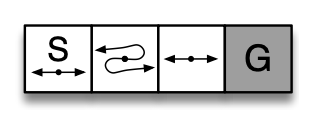

We are going to implment the REINFORCE algorithm and evaluate it on this environment.

In [1]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from tqdm import tqdm

def true_value(p):
    """ True value of the first state
    Args:
        p (float): probability of the action 'right'.
    Returns:
        True value of the first state.
        The expression is obtained by manually solving the easy linear system
        of Bellman equations using known dynamics.
    """
    return (2 * p - 4) / (p * (1 - p))


class ShortCorridor:
    """
    Short corridor environment
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.state = 0

    def step(self, go_right):
        """
        Args:
            go_right (bool): chosen action
        Returns:
            tuple of (reward, episode terminated?)
        """
        if self.state == 0 or self.state == 2:
            if go_right:
                self.state += 1
            else:
                self.state = max(0, self.state - 1)
        else:
            if go_right:
                self.state -= 1
            else:
                self.state += 1

        if self.state == 3:
            # terminal state
            return 0, True
        else:
            return -1, False

def softmax(x):
    t = np.exp(x - np.max(x))
    return t / np.sum(t)



**Question 1: REINFORCE algorithm**

In this part, you need to implement the REINFORCE algorithm. You will need to do the following:        
(1) Initialize a differentiable policy parameterized by $\theta$.                 
(2) Generate an episode with policy. Keep rolling out to get new state s1, reward r and done d from environment until the terminate state.

(3) Calculate returns $G$ for each step of the episode $t = 0, 1, \ldots, T-1$.                         
(4) Update policy.                                                          

Enter your code in the block.

In [ ]:
class ReinforceAgent:
    """
    ReinforceAgent that follows algorithm
    'REINFORNCE Monte-Carlo Policy-Gradient Control (episodic)'
    """
    def __init__(self, state_size, action_size, lr=0.01, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.theta = np.zeros((state_size, action_size))
        self.lr = lr

    def policy(self, state):
        return softmax(self.theta[state])
    
    def select_action(self, state):
        probs = self.policy(state)
        return np.random.choice(len(probs), p=probs)
    
    def generate_episode(self, env):
        episode = []        # store state, action and reward of each round
        env.reset()         # initialize the environment
        state = env.state   # initialize the state
        done = False        # initialize the state of done
        while not done:
            # make a move and store the reward and state
            action = self.select_action(state)
            reward, done = env.step(action == 1)
            episode.append((state, action, reward))
            state = env.state
        return episode
    
    def compute_returns(self, rewards):
        # initialize the returns to 0
        G = np.zeros_like(rewards, dtype=np.float32)
        cumulative = 0
        # calculate and store the rewards of each step
        for t in reversed(range(len(rewards))):
            cumulative = rewards[t] + self.gamma * cumulative
            G[t] = cumulative
        return G

    def update_policy(self, episode):
        # store the information
        states = []
        actions = []
        rewards = []
        for state, action, reward in episode:
            states.append(state)
            actions.append(action)
            rewards.append(reward)
        returns = self.compute_returns(rewards)
        for t in range(len(episode)):   # time step
            state = states[t]
            action = actions[t]
            # Policy gradient
            probs = self.policy(state)
            grad = np.zeros_like(self.theta)
            grad[state, action] = 1 - probs[action]
            for a in range(len(probs)):
                if a != action:
                    grad[state, a] = -1*probs[a]
            # Update theta
            self.theta += self.lr * returns[t] * grad
    
    def train(self, env, num_episodes=1000):
        rewards_per_episode = []
        for _ in tqdm(range(num_episodes)):
            episode = self.generate_episode(env)
            self.update_policy(episode)
            rewards = []
            for state, action, reward in episode:
                rewards.append(reward)
            total_reward = sum(rewards)
            rewards_per_episode.append(total_reward)
        return rewards_per_episode
        

**Question 2: REINFORCE with baseline (episodic)**

In this section, you need to implement another version of REINFORCE with baseline. Addition to the implementation in vanilla REINFORCE, you need to add a differentiable state-value function w, which is initialized as self.w = 0. You need to use this w as the baseline to reduce the variance of REINFORCE by replacing $G$ with advantage $\delta = G - w$. Then you can update w and $\theta$ as

$\begin{aligned}
& \mathbf{w} \leftarrow \mathbf{w}+\alpha^{\mathbf{w}} \delta \nabla \hat{v}\left(S_t, \mathbf{w}\right) \\
& \boldsymbol{\theta} \leftarrow \boldsymbol{\theta}+\alpha^{\boldsymbol{\theta}} \gamma^t \delta \nabla \ln \pi\left(A_t \mid S_t, \boldsymbol{\theta}\right)
\end{aligned}$.

For more details about the algorithm, refer to the lecture notes LN17 or Chapter 13 "REINFORCE with Baseline (episodic)" in the book "Reinforcement learning: an introduction" by Richard Sutton.

Enter your code in the block.

In [8]:
class ReinforceBaselineAgent(ReinforceAgent):
    def __init__(self, state_size, action_size, lr_policy=0.01, lr_value=0.01, gamma=0.99):
        super().__init__(state_size, action_size, lr_policy, gamma)
        self.w = np.zeros(state_size)
        self.lr_value = lr_value

    def value_function(self, state):
        return self.w[state]

    def compute_advantages(self, states, rewards):
        returns = self.compute_returns(rewards)
        advantages = np.zeros_like(returns, dtype=np.float32)
        for t, state in enumerate(states):
            advantages[t] = returns[t] - self.value_function(state)
        return advantages
    
    def update_value_function(self, states, advantages):
        for t, state in enumerate(states):
            grad_w = 1
            self.w[state] += self.lr_value * advantages[t] * grad_w

    def update_policy(self, episode):
        # store the information
        states = []
        actions = []
        rewards = []
        for state, action, reward in episode:
            states.append(state)
            actions.append(action)
            rewards.append(reward)
        advantages = self.compute_advantages(states, rewards)
        self.update_value_function(states, advantages)
        for t in range(len(episode)):
            state = states[t]
            action = actions[t]
            probs = self.policy(state)
            grad = np.zeros_like(self.theta)
            grad[state, action] = 1 - probs[action]
            for a in range(len(probs)):
                if a != action:
                    grad[state, a] = -1*probs[a]
            self.theta += self.lr * (advantages[t]) * grad
            

**Question 3.1: Evaluation with different learning rate in REINFORCE**

In this part, we will show the performance of REINFORCE on the short-corridor gridworld with different hyperparameter $\alpha$ settings as {2e-3, 2e-4, 2e-5}. The number of trials is 100, and the number of episode is 1000. Discount rate is  $\gamma=1$.

You need to plot the results which show the total reward on episode with these three different learning rates, which is averaged over 100 runs.

In [9]:
def Q3_1():
    num_trials = 100
    num_episodes = 1000
    gamma = 1
    learning_rates = [2e-3, 2e-4, 2e-5]
    env = ShortCorridor()

    # Store results
    results = {}
    for lr in learning_rates:
        results[lr] = np.zeros(num_episodes)
    for lr in learning_rates:
        for trial in tqdm(range(num_trials), desc=f"LR={lr}"):
            agent = ReinforceAgent(state_size=4, action_size=2, lr=lr, gamma=gamma)
            rewards = agent.train(env, num_episodes=num_episodes)
            results[lr] += np.array(rewards)
    # Average results over all trials
    for lr in learning_rates:
        results[lr] /= num_trials
    # Plot results
    plt.figure(figsize=(10, 6))
    for lr in learning_rates:
        plt.plot(results[lr], label=f"Learning Rate = {lr}")
        plt.title("Performance of REINFORCE with Different Learning Rates")
        plt.xlabel("Episodes")
        plt.ylabel("Average Total Reward")
        plt.legend()
        plt.grid(True)
        plt.show()


In [10]:
Q3_1()

LR=2e-05: 100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


**Question 3.2: Evaluation of REINFORCE w/o baseline**

In this part, we will show the performance of REINFORCE and REINFORCE-with-baseline on the short-corridor gridworld. The hyperparameter $\alpha$ for REINFORCE is set as {2e-4}. The hyperparameter $\alpha, \alpha^w$ for REINFORCE with baseline is set as {2e-3, 2e-2}. The number of trials is 100, and the number of episode is 1000. Discount rate is  $\gamma=1$.

You need to plot the results which show the total reward on episode with these three different learning rates, which is averaged over 100 runs.

In [11]:
def Q3_2():
    num_trials = 100
    num_episodes = 1000
    gamma = 1
    alpha = 2e-4
    reinforce_baseline_params = [(2e-3, 2e-2)]  # (alpha_theta, alpha_w)
    # Initialize environment
    env = ShortCorridor()
    # Store results
    results = {
        "REINFORCE": np.zeros(num_episodes),
        "REINFORCE with Baseline": {params: np.zeros(num_episodes) for params in reinforce_baseline_params},
    }
    # Evaluate REINFORCE
    for trial in tqdm(range(num_trials), desc="Evaluating REINFORCE"):
        agent = ReinforceAgent(state_size=4, action_size=2, lr=alpha, gamma=gamma)
        rewards = agent.train(env, num_episodes=num_episodes)
        results["REINFORCE"] += np.array(rewards)
    # Average results for REINFORCE
    results["REINFORCE"] /= num_trials
    # Evaluate REINFORCE with Baseline
    for alpha_theta, alpha_w in reinforce_baseline_params:
        for trial in tqdm(range(num_trials), desc=f"Evaluating REINFORCE with Baseline (α={alpha_theta}, αw={alpha_w})"):
            agent = ReinforceBaselineAgent(
                state_size=4,
                action_size=2,
                lr_policy=alpha_theta,
                lr_value=alpha_w,
                gamma=gamma,
            )
            rewards = agent.train(env, num_episodes=num_episodes)
            results["REINFORCE with Baseline"][(alpha_theta, alpha_w)] += np.array(rewards)
        # Average results for REINFORCE with Baseline
        results["REINFORCE with Baseline"][(alpha_theta, alpha_w)] /= num_trials
    # Plot results
    plt.figure(figsize=(10, 6))
    # Plot REINFORCE
    plt.plot(results["REINFORCE"], label=f"α={alpha}")
    # Plot REINFORCE with Baseline
    for (alpha_theta, alpha_w), rewards in results["REINFORCE with Baseline"].items():
        plt.plot(rewards, label=f"REINFORCE with Baseline α={alpha_theta}, αw={alpha_w}")
        plt.title("Performance Comparison: REINFORCE vs. REINFORCE with Baseline")
        plt.xlabel("Episodes")
        plt.ylabel("Average Total Reward")
        plt.legend()
        plt.grid(True)
        plt.show()


In [12]:
Q3_2()

100%|██████████| 1000/1000 [00:00<00:00, 6390.97it/s]:  99%|█████████▉| 99/100 [00:16<00:00,  6.14it/s]
Evaluating REINFORCE with Baseline (α=0.002, αw=0.02): 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]
